# RNN範例

In [3]:
# coding: utf-8

# 匯入Keras及SVG等函式庫

In [4]:
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.layers.wrappers import TimeDistributed

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


## 匯入IMDB資料庫

In [5]:
from keras.datasets import imdb

## 匯入Numpy等工具

In [6]:
from keras.utils import to_categorical, np_utils
import numpy as np

## 資料數，特徵數，向量維度，Step數

In [31]:
train_reviews = 5000
valid_reviews = 100
max_features = 5000
embedding_size = 256
step_size = 5
batch_size = 32
index_from = 2
rnn_units = 128
epochs = 2
word_index_prev = {'<PAD>': 0, '<START>': 1, '<UNK>': 2}

## 讀入IMDB資料

In [8]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, index_from=index_from)

17465344/17464789 [==============================] - 13s 1us/step


## 抽取IMDB中的單字

In [9]:
word_index = {word: (index + index_from) for word, index in imdb.get_word_index().items() if (index + index_from) < max_features}
word_index.update(word_index_prev)

1646592/1641221 [==============================] - 2s 1us/step


## 以單字資訊製作字典

In [10]:
index_word = {index: word for word, index in word_index.items()}

## 顯示文章函式

In [11]:
def print_sentence(sentence):
    for index in sentence:
        print(index_word[index], end=" ")
    print()

## 顯示第一篇文章

In [12]:
print_sentence(x_train[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they

## 將資料分為學習以及測試資料

In [13]:
data_train = [t for s in x_train[:train_reviews] for t in s]
data_valid = [t for s in x_train[train_reviews:train_reviews+valid_reviews] for t in s]

## 批次處理的函式定義

In [14]:
def batch_generator(data, batch_size, step_size):
    seg_len = len(data) // batch_size
    steps_per_epoch = seg_len // step_size
    data_seg_list = np.asarray([data[int(i*seg_len):int((i+1)*seg_len)] for i in range(batch_size)])
    data_seg_list
    i = 0
    while True:
        x = data_seg_list[:, int(i*step_size):int((i+1)*step_size)]
        y = np.asarray([to_categorical(data_seg_list[j, int(i*step_size+1):int((i+1)*step_size+1)], max_features) for j in range(batch_size)])
        yield x, y
        i += 1
        if i >= steps_per_epoch:
            i = 0

## 使用LSTM的設計模型

In [16]:
w = Input(shape=(step_size,), name='Input')
x = Embedding(input_dim=max_features, output_dim=embedding_size, name='Embedding')(w)
y = LSTM(units=rnn_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, name='LSTM')(x)
w_next = TimeDistributed(Dense(units=max_features, activation='softmax', name='Dense'), name='TimeDistributed')(y)

## 製作模型

In [17]:
model = Model(inputs=[w], outputs=[w_next])

## 顯示模型

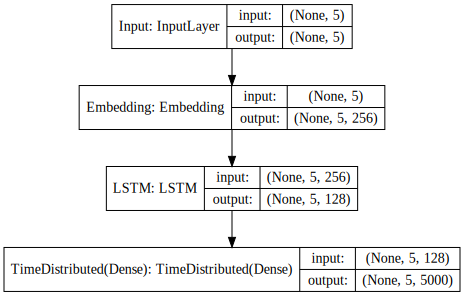

In [18]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 編譯模型

In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## 製作批量處理的資料集

In [21]:
gen_train = batch_generator(data_train, batch_size, step_size)
gen_valid = batch_generator(data_valid, batch_size, step_size)

## 計算Step數

In [22]:
steps_per_epoch_train = len(data_train) / batch_size / step_size
steps_per_epoch_valid = len(data_valid) / batch_size / step_size

## 批次逐次對資料學習

In [24]:
model.fit_generator(generator=gen_train, steps_per_epoch=steps_per_epoch_train, epochs=epochs,
                    validation_data=gen_valid, validation_steps=steps_per_epoch_valid)

Epoch 1/2
7620/7619 [==============================] - 267s 35ms/step - loss: 5.4899 - acc: 0.1719 - val_loss: 5.4978 - val_acc: 0.1709
Epoch 2/2
7620/7619 [==============================] - 261s 34ms/step - loss: 5.6126 - acc: 0.1731 - val_loss: 5.5772 - val_acc: 0.1714


## 挑選接著出現單字的函式

In [35]:
def sample(preds, temperature=1.0):
    preds = np.log(preds) / temperature
    preds = np.exp(preds) / np.sum(np.exp(preds))
    choices = range(len(preds))
    return np.random.choice(choices, p=preds)

## 隨機生成文章的函式

In [36]:
def sample_sentences(num_sentences, sample_sent_len = 20):
    for x_test_i in x_test[:num_sentences]:
        x = np.zeros((1, step_size))
        sentence = x_test_i[:step_size]

        for i in range(sample_sent_len):
            for j, index in enumerate(sentence[-step_size:]):
                x[0, j] = index
            preds = model.predict(x)[0][-1]
            next_index = sample(preds)
            sentence.append(next_index)

        print_sentence(sentence)

## 隨機抽出文章

In [37]:
sample_sentences(num_sentences=20, sample_sent_len=15)

<START> please give this one <UNK> it actually makes it having him the first time just though they were at 
<START> this film requires a movie <UNK> who <UNK> <UNK> are foster this was 8 then stop the town in 
<START> many animation buffs consider it i'm some of name their own horror wonderful movie turns on your hands of 
<START> i generally love this film is a third <UNK> br br overall i be enjoyed walk the original overall 
<START> like some other people are a john easily <UNK> <UNK> one of the fact how many being <UNK> and 
<START> i'm absolutely <UNK> this is his character for imdb to play if their talent they worse other scenes are 
<START> originally supposed to be better to watch the film particularly made before a comments into mind someone here the 
<START> the <UNK> richard <UNK> as i get up with a little <UNK> about the <UNK> of this movie i 
<START> hollywood had a long guy who kills someone we are the character went on the entertaining <UNK> and <UNK> 
<START> this film i

## 把weight正規化

In [28]:
norm_weights = np_utils.normalize(model.get_weights()[0])

## 顯示意義相近單字的函式

In [29]:
def print_closest_words(word, nb_closest=10):
    index = word_index[word]
    distances = np.dot(norm_weights, norm_weights[index])
    c_indexes = np.argsort(np.squeeze(distances))[-nb_closest:][::-1]
    for c_index in c_indexes:
        print(index_word[c_index], distances[c_index])

## 顯示意義相近的單字

In [42]:
words = ["we",
         "big",
         "great",
         "money",
         "years",
         "king",
         "woman",
         "man",
         "book",
        ]

for word in words:
    if word in word_index:
        print('====', word)
        print_closest_words(word)

==== we
we 1.0
they 0.74794316
you 0.6924391
filmmakers 0.55942297
you'll 0.52848184
people 0.52046615
makers 0.5174731
you'd 0.5106005
villains 0.5071005
doesn't 0.50162345
==== big
big 1.0000001
huge 0.64229536
small 0.588405
high 0.58337325
major 0.51908267
old 0.5152005
our 0.5070703
low 0.49837393
sole 0.49291587
upper 0.49155617
==== great
great 0.9999998
decent 0.7066626
good 0.7056813
wonderful 0.68405986
excellent 0.6526166
fine 0.6511426
terrific 0.62871826
supporting 0.6087383
outstanding 0.59913146
stellar 0.58065677
==== money
money 1.0
happen 0.5168859
material 0.50648415
sleep 0.48361927
happened 0.4795894
effort 0.47818303
laugh 0.47398353
sequel 0.46956882
happens 0.46887144
him 0.45606524
==== years
years 1.0
year 0.6958463
decades 0.54066837
sit 0.5216108
decade 0.503459
months 0.47880787
halfway 0.47178888
weeks 0.458314
sat 0.45318472
days 0.4485622
==== king
king 1.0
director 0.43279588
master 0.42525703
j 0.41008282
sister 0.40408778
daughter 0.3985269
producer 0